# What are the Current Risks of Contracting COVID-19 with/without Mitigation Measures?
Throughout the pandemic we have been inundated with data, such as the number of daily confirmed cases, cases per 100k of population, case fatality rates, r numbers, fractfions of positive tests, etc, and while there is no doubt that a real-time feed of reliable data can be incredibly useful, there is also a risk of information overload. This can make it more difficult for people to tune-in to what matters, making it harder for them to evaluate their own personal risk, such as the likelihood that they might become infected. For example, for most of us, knowing that our 14 day confirmed case total is 30 per 100,000 of population is not all that helpful when it comes to evaluating the concrete infection risk that such a number entails, or what this means over some meaningful period of time, such as next week, or the coming school term, or between now and the new year.

A further complication is that the confirmed cases we hear about will underestimate the true number of infections; for example, several studies ([1](https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2766237?utm_source=For_The_Media&utm_medium=referral&utm_campaign=ftm_links&utm_term=052720), [2](https://www.nature.com/articles/s41591-020-0869-5), [3](https://www.cdc.gov/mmwr/volumes/69/wr/mm6914e1.htm?s-cid=mm6914e1_e&deliveryName=USCDC_921-DM24694)), have highlighted high percentages of asymptomatic and pre-symptomatic cases, while other infections can be mild enough to prevent sufferers from getting tested. If we wish to estimate the actual risk of infection then we need  an estimate for the true number of infected individuals at a given point in time.

The purpose of this article is to quantify the current level of infection risk in Ireland, and elsewhere, by estimating the probability of becoming infected over a specific period of time. We do this in the following way:
1. We use daily confirmed cases and test positivity rates to estimate the true number of daily infections, so that we can compute the current infection prevalence; that is the number of currently individuals taty present an infection risk to others.
2. Infection prevalence can be used with population data to estimate the chance that a close-contact event will occur with an infected individual, which we treat as a necessary precondition for infection.
3. Then, using the likelihood of transmission from such a contact event, we calculate the probability of becoming infected over a specific period of time (week, month etc) to provide a more interpretable assessment of risk.
4. Finally, we compare this risk across different European countries and we evaluate the capacity of different mitigation measures to reduce this risk.

It is important to state that this approach is primarily designed to communicate infection risk at a specific point in time and for a short period into the future. It is not a forecasting model and it is not appropriate to use use infection risk to predict future infection rates.

In [81]:
from datetime import date, datetime, timedelta

import itertools


import pandas as pd
import numpy as np

from loguru import logger
import pycountry

from matplotlib.pylab import plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



import seaborn as sns

import plotly.io as pio
import plotly_express as px

import chart_studio.plotly as py
import chart_studio

from IPython.display import clear_output


import sys
import os
sys.path.insert(0, os.path.abspath('../../src/'))
import pipeline

import scipy.stats as ss

import geopandas as gpd

%matplotlib inline

!pwd

/home/barry/projects/covid_projects/predicting_true_cases/notebooks


# Load Base OWID dataset

In [82]:
df = pd.read_pickle('../../generating_covid_datasets/data/base_owid.pkl')
df.shape, df['country'].nunique(), df.date.max()

((42838, 10), 208, Timestamp('2020-09-14 00:00:00'))

# Infection Prevalence – The Youyang Gu Model

There are a variety of models that have been developed for estimating teh tyrue number of COVID-19 infections given a variety of other measures. We use the (Youyang Gu)[https://covid19-projections.com/estimating-true-infections/] model, mostly because it is straightforward to compute, relies on available confirmed case and test positivity data, and appears to be reasoanbly accurate.

The Youyang Gu model begins with the positivity rate, the fraction of tests on a given day that come back positive. The intuition is that a higher positivity rate is associated with higher true infection prevalence, and that this can be approximated by a formula of the following form:.

$prevalence\text{-}ratio = a \times positivity\text{-}rate^{b} + c$

The trick is, figuring out what *a*, *b*, and *c* should be. Fortunately for us, Youyang has done this by using curve fitting on historical test positivity and serological surveys, as well as some trial & error, to find that the following approximation works well in practice:

$prevalence\text{-}ratio = 16 \times positivity\text{-}rate^{\frac{1}{2}} + 2.5$

And so, for a given date we can estimate the true number of infected cases using:

$true\text{-}infected = prevalence\text{-}ratio \times new\text{-}cases$

## Using 7d Rolling means
We work from 7d rolling means to smooth out irregularities in daily case/test data.

In [83]:
df = df.pipe(lambda df: pipeline.compute_rolling(df, cols_like='new_'))
df.head()

,country,date,country_code,country_id,continent,region,new_cases,new_deaths,new_tests_smoothed,population,new_cases_rolling,new_deaths_rolling,new_tests_smoothed_rolling
0,Aruba,2020-03-13,ABW,AW,North America,carribean,2.0,0.0,NaN,106766.0,2.0,0.0,NaN
1,Aruba,2020-03-19,ABW,AW,North America,carribean,NaN,NaN,NaN,106766.0,2.0,0.0,NaN
2,Aruba,2020-03-20,ABW,AW,North America,carribean,2.0,0.0,NaN,106766.0,2.0,0.0,NaN
3,Aruba,2020-03-21,ABW,AW,North America,carribean,NaN,NaN,NaN,106766.0,2.0,0.0,NaN
4,Aruba,2020-03-22,ABW,AW,North America,carribean,NaN,NaN,NaN,106766.0,2.0,0.0,NaN


## Positivity Rate & Prevalence Ratio
Yousing the Youyang Gu formula above we use the positivity rate to calculate the prevalence ration and use it to estimate the true infections.

In [84]:
df['positivity_rate'] = df['new_cases_rolling']/df['new_tests_smoothed_rolling']
df['prevalence_ratio'] = (16*(df['positivity_rate']**.5))+2.5
df['new_infections_rolling'] = df['new_cases_rolling'] * df['prevalence_ratio']

In [85]:
# Some 

df = df\
    .pipe(pipeline.compute_per_100k)\
    .pipe(lambda df: pipeline.compute_prevalence(df, cases_col='new_cases_rolling'))\
    .pipe(lambda df: pipeline.compute_prevalence(df, cases_col='new_infections_rolling'))
#     .pipe(lambda df: pipeline.compute_rel_num(df, cols_like='_rolling'))\


## An Example
Here's what this means for Ireland. The 7-day rolling average of the test positivity rate is shown below as the shaded red curve, and we can see how it peaked in April at close to 20% compared to about 2% today. 

The confirmed cases also peaked in April (hitting an maximun 7-day rolling average of just over 900 case per day) before dropping precipitously during the Summer, and then climbing to approximately 100 cases per day today. 

As expected, the estimated number of infections, also presented on a log axis, is much higher than the confirmed cases, about 10x higher in April, in part due to April's high positivity rate --  and back then the estimated number of daily infections peaked at just over 8,200 case per day (April 16) -- while today infections have fallen to just over 500 per day.

These curves are presented on a log axis so that the lows of the summer can be more readily distinguished against spring highs but it also means that the case look much closer to infections than they actually area.

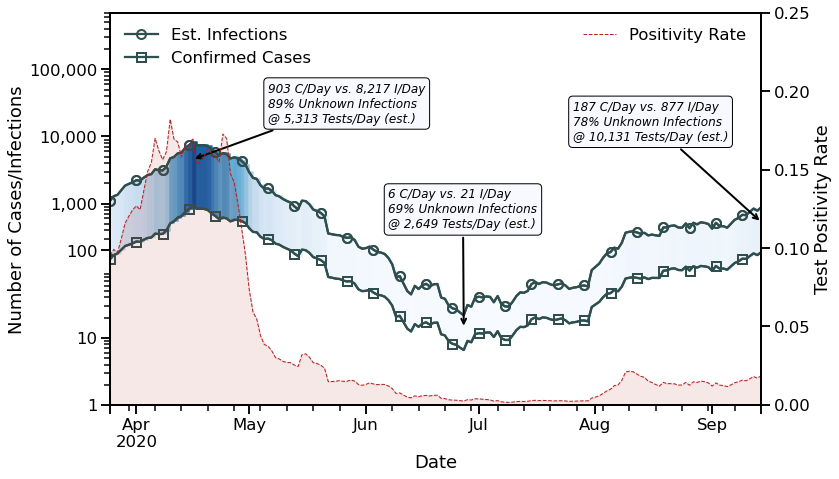

In [86]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(12, 7))
bx = ax.twinx()

country = 'Ireland'

data =  df[df['country']==country].set_index('date')[['positivity_rate', 'new_cases_rolling', 'new_infections_rolling']].dropna()


bx.set_ylim(0, .25)
data['positivity_rate'].plot(ax=bx,lw=1, ls='--', c='firebrick', zorder=-100)
bx.fill_between(data.index, 0, data['positivity_rate'], color='firebrick', alpha=.1, zorder=-100)


# Need to do these before the fill
data['new_infections_rolling'].plot(ax=ax, marker='o', markeredgewidth=2, markerfacecolor='none', markevery=7, c='darkslategrey')   
data['new_cases_rolling'].plot(ax=ax, marker='s', markeredgewidth=2, markerfacecolor='none', markevery=7, c='darkslategrey')


# Shade the unknown infections
use_cmap = matplotlib.cm.get_cmap('Blues')

data.apply(
    lambda row: ax.fill_between(
        [row.name, row.name+timedelta(days=1)],
        [row['new_cases_rolling']], [row['new_infections_rolling']],
        color = use_cmap((row['new_infections_rolling']-row['new_cases_rolling'])/(data['new_infections_rolling'].max()))
    ), axis=1
)

# for date, row in data.iterrows():
#     y1, y2 = row['new_cases_rolling'], row['new_infections_rolling'] 
#     rel_diff = y1/y2
#     color = use_cmap((rel_diff/(data['new_cases_rolling']/data['new_infections_rolling']).max())**1)
#     ax.fill_between([date, date+timedelta(days=1)], [y1], [y2], color=color, alpha=1)


# Overwrite ontop of the fill
data['new_infections_rolling'].plot(ax=ax, marker='o', markeredgewidth=2, markerfacecolor='none', markevery=7, c='darkslategrey')   
data['new_cases_rolling'].plot(ax=ax, marker='s', markeredgewidth=2, markerfacecolor='none', markevery=7, c='darkslategrey')



ax.set_yscale('log')

ax.set_ylim(100, 700000)


ax.set_yticks([1, 10, 200, 1000, 10000, 100000])
ax.set_yticklabels(['1', '10', '100', '1,000', '10,000', '100,000'])

ax.set_ylabel('Number of Cases/Infections')
bx.set_ylabel('Test Positivity Rate')

ax.set_xlabel('Date')

ax.legend(['Est. Infections', 'Confirmed Cases'], loc='upper left', frameon=False)
bx.legend(['Positivity Rate'], loc='upper right', frameon=False)


# Annotations
test_per_day = data['new_cases_rolling']/data['positivity_rate']


# Peak Unknown

def annotate_unknowns(data, unknown_date, label_date_offset=30, label_value_offset=5):
    unknown_value = (data['new_infections_rolling']/data['new_cases_rolling']).max()

    unknown_cases = data.loc[unknown_date]['new_cases_rolling']
    unknown_infections = data.loc[unknown_date]['new_infections_rolling']
    unknown_pct = int(100*(unknown_infections-unknown_cases)/unknown_infections)
    tests_per_day = test_per_day.loc[unknown_date]

    ax.annotate(
        '{:,} C/Day vs. {:,} I/Day\n{}% Unknown Infections\n@ {:,} Tests/Day (est.)'.format(
            int(unknown_cases//1*1), int(unknown_infections//1*1), unknown_pct, int(tests_per_day//1*1)
        ), 
        xy=(unknown_date, (unknown_cases+unknown_infections)/2), 
        xytext=(unknown_date+timedelta(days=label_date_offset), unknown_infections*label_value_offset),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=2),
        bbox=dict(facecolor='ghostwhite', edgecolor='black', boxstyle='round,pad=.35', lw=1), 
        fontsize=12, style='oblique', ha='left')

    
peak_unknown_date = data['new_cases_rolling'].idxmax()
min_unknown_date = data['new_cases_rolling'].idxmin()
curr_unknown_date = data.index[-1]

annotate_unknowns(data, peak_unknown_date, label_date_offset=20, label_value_offset=2)
annotate_unknowns(data, min_unknown_date, label_date_offset=-20, label_value_offset=20)
annotate_unknowns(data, curr_unknown_date, label_date_offset=-50, label_value_offset=10)





# ax.set_title('New Cases/Est. Infections (7d rolling avg.) in {} to {}'.format(country, data.index[-1].strftime('%d %b')))

fig.tight_layout()

[
    (data['new_cases_rolling'].iloc[-1]/data['new_cases_rolling'].max(), data['new_cases_rolling'].iloc[-1], data['new_cases_rolling'].max()), 
    (data['new_infections_rolling'].iloc[-1]/data['new_infections_rolling'].max(), data['new_infections_rolling'].iloc[-1], data['new_infections_rolling'].max()),
    data['new_infections_rolling'].max()/data['new_cases_rolling'].max(), (data['new_infections_rolling'].iloc[-1]/data['new_cases_rolling'].iloc[-1]), 
]

fig.savefig('../graphs/cases_infections_by_date_ireland.png', format='png', dpi=200)

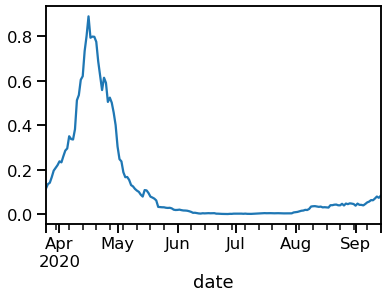

In [87]:
((data['new_infections_rolling']-data['new_cases_rolling'])/(data['new_infections_rolling'].max())).plot()

We see here that during peak cases in spring it is estimated that confirmed cases only accounted for about 11% of total infections. In other words 89% of infections were unaccounted for. By the same logic, there are 77% unknown infections now. One way to think about this is that despite very significant scale-up in testing (>3x more tests per day current compared with April), there remains a significant quantity of unknown cases -- it's nowhere near as high as in April but it's far from trivial at the same time -- and even in the lows of summer the unknown infection rate was never less than 68%.

## Infection Prevalence
Next we calculate the 14-day infection prevalence. This is the running total of estimated infections over the last 14 days. This represents the current pool of infectous individuals, assuming that they remain infectous for a 14-day period; 14 days was chosen because it matches the recomended quarantine duration.

_Note_: Strictly speaking it would make sense to shift these infection estimates back a few days since the confirmed cases that led to them actually became infected a few days previously. For now we don't do this.

One thing to bear in mind is that, presumably when someone is feeling unwell they will have the common-sense to self-isolate so that they will no longer present an infection risk to others. Accordingly, we need to estimate the pool of infectious individuals who remain in circulation. This will include asymptomatic and pre-symptomatic people (because they don't know to self-isolate) but, unfortunately, it will probably also include some infected people who choose not to self-isolate or get tested, for whatever reason.

To estimate this pool of infected individuals who remain in circulation this we calculate an _adjusted_prevalence_ in the following way:
1. We assume that confirmed cases have been infectous for 7d before testing positive, and calculate the sum of confirmed cases for the preceding 7 days.
2. For the remaining infectous individuals we (a) perform a similar calculation on 60% (these are people who were sick enough and responsible enough to self-isolate after a week) and (b) assume that the remaining 40% remain infectous for 14 days, but fail to isolate (we assume 20% asymptomatic and 20% mild and not isolating).

The adjusted infectous prevalence is the sum of these 3 components.

In [88]:
df['unconfirmed_cases_rolling'] = df['new_infections_rolling']-df['new_cases_rolling']


frac_asymptomatic = 0.4
frac_asymptomatic_mobile = 0.5

short_infectious_period = '7d'
long_infectious_period = '14d'

# Confirmed cases today are estimated to be infectious for 7 days, from fay -9 to -2.
confirmed_cases_prevalence = df.groupby('country').apply(
    lambda g: g.set_index('date')[['new_cases_rolling']].shift(2).rolling(short_infectious_period).sum()
).rename(columns={'new_cases_rolling': 'confirmed_cases_prevalence'})

# Unconfirmed, asymptomatic cases are infectious for the last 14 days.
unconfirmed_asymptomatic_prevalence = df.groupby('country').apply(
    lambda g: (g.set_index('date')[['unconfirmed_cases_rolling']]*frac_asymptomatic).rolling(long_infectious_period).sum()
).rename(columns={'unconfirmed_cases_rolling': 'unconfirmed_asymptomatic_prevalence'})

# Unconfirmed, symptomatic, mobile cases are also infectious for the last 14 days
unconfirmed_symptomatic_mobile_prevalence = df.groupby('country').apply(
    lambda g: (g.set_index('date')[['unconfirmed_cases_rolling']]*(1-frac_asymptomatic)*frac_asymptomatic_mobile).rolling(long_infectious_period).sum()
).rename(columns={'unconfirmed_cases_rolling': 'unconfirmed_symptomatic_mobile_prevalence'})

# Unconfirmed, symptomatic, self-isolating cases are also infectious for the last 7 days.
unconfirmed_symptomatic_self_isolating_prevalence = df.groupby('country').apply(
    lambda g: (g.set_index('date')[['unconfirmed_cases_rolling']]*(1-frac_asymptomatic)*(1-frac_asymptomatic_mobile)).rolling(short_infectious_period).sum()
).rename(columns={'unconfirmed_cases_rolling': 'unconfirmed_symptomatic_self_isolating_prevalence'})



prevalence = pd.concat([
    confirmed_cases_prevalence, 
    unconfirmed_asymptomatic_prevalence, 
    unconfirmed_symptomatic_mobile_prevalence, unconfirmed_symptomatic_self_isolating_prevalence
], axis=1)


df = df.set_index(['country', 'date']).join(prevalence).reset_index()

df['effective_prevalence'] = df[prevalence.columns].sum(axis=1)

df.sample()

,country,date,country_code,country_id,continent,region,new_cases,new_deaths,new_tests_smoothed,population,...,new_tests_smoothed_rolling_per_100k,new_infections_rolling_per_100k,new_cases_rolling_prevalence_14d,new_infections_rolling_prevalence_14d,unconfirmed_cases_rolling,confirmed_cases_prevalence,unconfirmed_asymptomatic_prevalence,unconfirmed_symptomatic_mobile_prevalence,unconfirmed_symptomatic_self_isolating_prevalence,effective_prevalence
28897,New Caledonia,2020-04-26,NCL,NC,Oceania,melanesia_micronesia_polynesia,0.0,0.0,NaN,285491.0,...,NaN,NaN,-5.551115e-15,NaN,NaN,3.552714e-15,NaN,NaN,NaN,3.552714e-15


In [89]:
total_prevalence = df.groupby('country').apply(
    lambda g: g.set_index('date')[['new_infections_rolling']].rolling('14d').sum()
).rename(columns={'new_infections_rolling': 'total_prevalence'})

df = df.set_index(['country', 'date']).join(total_prevalence).reset_index()



In [90]:
# The number of isolating individuals
df['new_infections_rolling_isolating'] = df['new_cases_rolling']\
    + df['unconfirmed_cases_rolling']*(1-frac_asymptomatic)*(1-frac_asymptomatic_mobile)

df['new_infections_rolling_mobile'] = df['unconfirmed_cases_rolling']*frac_asymptomatic\
    + df['unconfirmed_cases_rolling']*(1-frac_asymptomatic)*frac_asymptomatic_mobile


(df[df['country']=='Ireland'].set_index('date')['new_infections_rolling_isolating']/df[df['country']=='Ireland'].set_index('date')['new_infections_rolling']).iloc[-1]

0.4496683355206003

(6922.404406282195, 8593.529421262067)

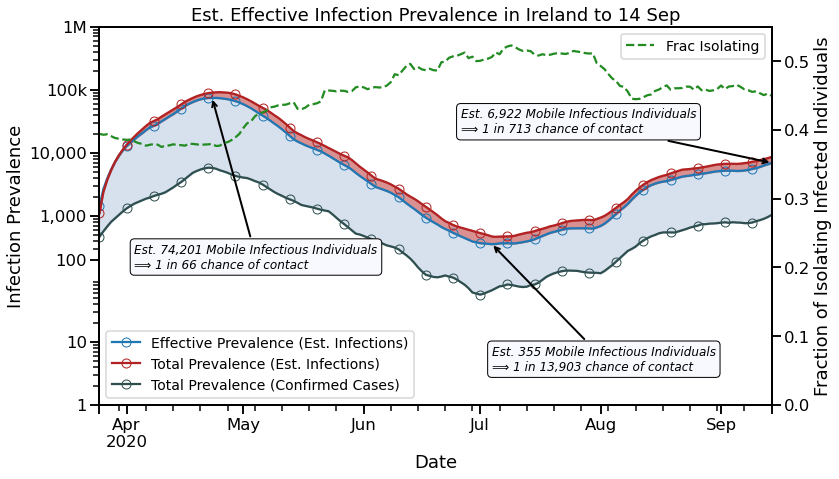

In [101]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(12, 7))

bx=ax.twinx()

country = 'Ireland'
pop = df[df['country']==country]['population'].unique()[0]

start_date = datetime(2020, 3, 25)
data =  df[df['country']==country].set_index('date')[['confirmed_cases_prevalence', 'effective_prevalence', 'total_prevalence', 'new_infections_rolling_isolating', 'new_infections_rolling', 'new_cases_rolling']].dropna().loc[start_date:]


# The fraction of isolating individuals
(data['new_infections_rolling_isolating']/data['new_infections_rolling']).plot(ax=bx, c='forestgreen', ls='--')


# The prevalence lines
data['effective_prevalence'].plot(ax=ax, marker='o', markerfacecolor='none', markevery=7)   
data['total_prevalence'].plot(ax=ax, marker='o', markerfacecolor='none', markevery=7, color='firebrick')   
data['confirmed_cases_prevalence'].plot(ax=ax, marker='o', markerfacecolor='none', markevery=7, c='darkslategrey')

# Shade the unknown infections
ax.fill_between(data['confirmed_cases_prevalence'].index, data['confirmed_cases_prevalence'], data['effective_prevalence'], color='lightsteelblue', alpha=.5)
ax.fill_between(data['effective_prevalence'].index, data['effective_prevalence'], data['total_prevalence'], color='firebrick', alpha=.5)

ax.set_yscale('log')

ax.set_ylim(100, 1000000)
ax.set_yticks([1, 10, 200, 1000, 10000, 100000, 1000000])
ax.set_yticklabels(['1', '10', '100', '1,000', '10,000', '100k', '1M'])

ax.set_ylabel('Infection Prevalence')
ax.set_xlabel('Date')

bx.set_ylabel('Fraction of Isolating Infected Individuals')

bx.set_ylim(0, .55)



ax.set_title('Est. Effective Infection Prevalence in {} to {}'.format(country, data.index[-1].strftime('%d %b')))


# Label the peak of adjusted prevalence

def annotate_prevalence(data, prevalence_date, pop, label_date_offset=30, label_value_offset=5):
    prevalence_value = (data['effective_prevalence']/data['confirmed_cases_prevalence']).max()

    prevalence_cases = data.loc[prevalence_date]['confirmed_cases_prevalence']
    prevalence_infections = data.loc[prevalence_date]['effective_prevalence']

    ax.annotate(
        'Est. {:,} Mobile Infectious Individuals\n⟹ 1 in {:,} chance of contact'.format(
            int(prevalence_infections//1*1), int(pop/prevalence_infections)
        ), 
        xy=(prevalence_date, prevalence_infections), 
        xytext=(prevalence_date+timedelta(days=label_date_offset), prevalence_infections*label_value_offset),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=2),
        bbox=dict(facecolor='ghostwhite', edgecolor='black', boxstyle='round,pad=.35', lw=1), 
        fontsize=12, style='oblique', ha='left')

        
peak_prevalence_date = (data['effective_prevalence']).idxmax()
min_prevalence_date = (data['effective_prevalence']).idxmin()
curr_prevalence_date = data.index[-1]

annotate_prevalence(data, peak_prevalence_date, pop=pop, label_date_offset=-20, label_value_offset=.002)
annotate_prevalence(data, min_prevalence_date, pop=pop, label_date_offset=0, label_value_offset=.01)
annotate_prevalence(data, curr_prevalence_date, pop=pop, label_date_offset=-80, label_value_offset=3)


ax.legend([
    'Effective Prevalence (Est. Infections)',
    'Total Prevalence (Est. Infections)',
    'Total Prevalence (Confirmed Cases)'
], loc='lower left', fontsize=14)

bx.legend(['Frac Isolating'], loc='upper right', fontsize=14)

fig.tight_layout()

fig.savefig('../graphs/infection_prevalence_for_ireland.png', format='png', dpi=200)

df[df['country']==country].set_index('date')['effective_prevalence'].iloc[-1], df[df['country']==country].set_index('date')['total_prevalence'].iloc[-1]



In [104]:
data['new_infections_rolling'].sum()

215457.10271207214

Here we see the fuller picture of prevalence. The lower bound shows the estimated prevalence based on confirmed cases, which is obviously a gross underestimate of true prevalence. 

Next, the upper bound is the total prevalence estimate, based on the estimated total number of infections and a 14 day infectious period. Some of these individuals will be isolating however, greatly limiting their transmission risk, but only after, and if, they develop symptoms, and even then not always. Based on the assumptions above--e.g. the fraction of asymptomatic cases, the number of infectious days prior to symptoms/confirmation, and the propensity to self-isolate-- the effective prevalence line estimates the number of mobile (non-isolating) infections, which corresponds to the main source of infectious contacts in the community.

On average the effective prevalence is approximately 80% of total prevalence in this analysis, which suggests that prevalence is only reduced by 20% due to isolation and quarantining. It is important to note that this does not mean that only 20% of people are isolating. The dashed green line shows the estimated fraction of infected individuals who isolate (whether on their own recogniscence or as a result of a confirmed test) and we can see that it ranges from just under 40% to just over 50%. It varies because of testing and our ability to identify confirmed cases –– by finding more infections we can isolate a greater proprtion of the infections that exist at any time –– but even if we could identify all of the infections (which is unlikely because many are asymptomatic) it is not reasonable to expect to be able to isolate everyone from the moment them become infectious. In the above analysis we model different groups to be isolating for diferent periods in an effort to capture this, and currently the effective prevalence is 76% of total prevalence with 45% of infected individuals spending at least some of their infectious period in isolation.

Obviously this type of approach depends on a lot of assumptions about the virus and how people will behave, and changing any one of these assumptions will change the end result. However, based on an initial sensitivity analysis, reasonable changes to key parameters do not materially change the trends as reprted. For example, if we reduce the fraction of symptomatic cases who remain mobile from 0.5 to 0.3 then the latest estimate of the number of infectious individuals falls from 5,541 to 5,218, a change of just over 5%. Or if we shorten the 7-day infectious period for confirmed/symptomatic individuals to 5 days, then 5,514 infections drops by 7%.

# The Probability of Infection over a Fixed Period
Now that we know the odds of coming into contact with an infected individual still in circulation, we can calculate the probbaility of such a contact event and use this as the basis of a calculate to estimate (a) the chances of becoming infected from such a contact event, and (b) the probability of becoming infected over a given period of time.

## Estimating the chances of coming into contact with an infected individual
The probability of coming into contact with an infected person is simply the proportion of such individuals in general circulation; that is, the adjusted prevalence divided by the population.

In [11]:
df['prob_infection_contact'] = df['effective_prevalence']/df['population']
df['odds_infection_contact'] = (df['population']/df['effective_prevalence'])

## Estimating Infection Risk
Infection risk depends on how many close contacts we have per day how we behave around these close contacts and in general there are four things that we can do to modify our risk of infection:
1. Reduce the average number of close contacts.
2. Practice good hand hygiene (shown to be 77% effective in reducing transmisson in this [study](https://gh.bmj.com/content/5/5/e002794));
3. 1m social distance associated with 12.8% risk of infection vs 2.6% at 2m; see [here](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)31142-9/fulltext).
4. Wearing a mask found to be 79% effective at reducing symptoms prioer to infection in the same [study](https://gh.bmj.com/content/5/5/e002794) as in 2 above; alternatively [this study](see [here](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)31142-9/fulltext) suggests an 82% reductyion as wearing a mask reduced infection risk ftom 17.4% to 3.1%.

By implementing these practices we can certainly lower our risk of infection, at least in ideal settings, but it is not clear how they work in combination or how effectively people tend to follow guidance. For simplicty, in what follows we will assume a conservative 50% reduction in transmission risk for each of the above, whether in isolation or in combing ation.

### Baseline Risk

In [12]:
risk_of_infection = .128  # The 1m risk of infection

df['prob_close_contact_transmission'] = df['prob_infection_contact']*risk_of_infection

df[df['country']=='Ireland'].iloc[-1]['prob_close_contact_transmission']

0.00017004552756692362

In [13]:
close_contacts_per_day = 15

def prob_of_infection(p=risk_of_infection, cc=close_contacts_per_day, days=1):
    return pd.Series(1-ss.binom.pmf(k=0, n=cc*days, p=p), index=p.index)

df['baseline_prob_of_infection_per_day'] = prob_of_infection(p=df['prob_close_contact_transmission'], cc=close_contacts_per_day, days=1)
df['baseline_prob_of_infection_per_week'] = prob_of_infection(p=df['prob_close_contact_transmission'], cc=close_contacts_per_day, days=7)
df['baseline_prob_of_infection_per_month'] = prob_of_infection(p=df['prob_close_contact_transmission'], cc=close_contacts_per_day, days=30)



df[df['country']=='Ireland'].set_index('date')['baseline_prob_of_infection_per_month'].dropna().max()

0.5795411120816635

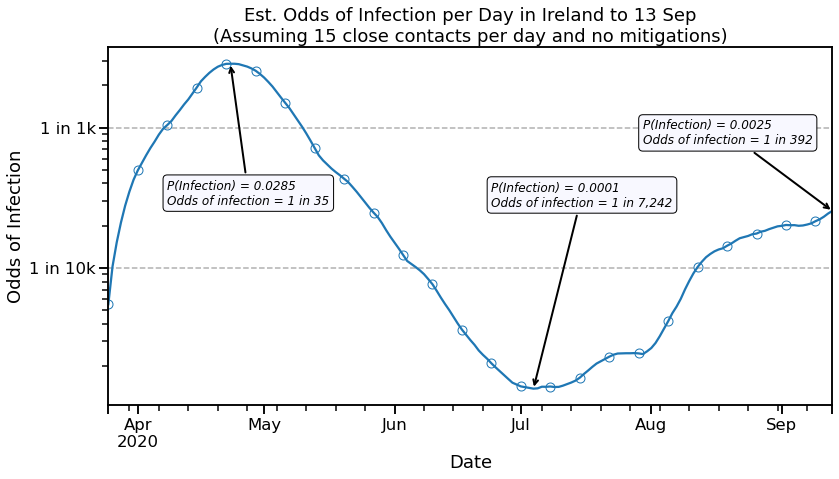

In [120]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(12, 7))


data = df[df['country']=='Ireland'].set_index('date').loc[start_date:][['prob_close_contact_transmission', 'baseline_prob_of_infection_per_day', 'baseline_prob_of_infection_per_week', 'baseline_prob_of_infection_per_month']]

data['baseline_prob_of_infection_per_day'].dropna().plot(ax=ax, marker='o', markerfacecolor='none', markevery=7)
# data['baseline_prob_of_infection_per_week'].dropna().plot(ax=ax, marker='o', markerfacecolor='none', markevery=7)
# data['baseline_prob_of_infection_per_month'].dropna().plot(ax=ax, marker='o', markerfacecolor='none', markevery=7)


ax.set_yscale('log')

ax.set_ylabel('Odds of Infection')
ax.set_xlabel('Date')

def annotate_probabilities(data, prob_date, prob_col, label_date_offset=30, label_value_offset=5):
    
    prob_value = data.loc[prob_date][prob_col]
    prob_odds = int(1/prob_value)
    
    ax.annotate(
        'P(Infection) = {}\nOdds of infection = 1 in {:,}'.format(round(prob_value, 4), prob_odds), 
        xy=(prob_date, prob_value), 
        xytext=(prob_date+timedelta(days=label_date_offset), prob_value*label_value_offset),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=2),
        bbox=dict(facecolor='ghostwhite', edgecolor='black', boxstyle='round,pad=.35', lw=1), 
        fontsize=12, style='oblique', ha='left')

prob_col = 'baseline_prob_of_infection_per_day'
peak_prob_date = (data[prob_col]).idxmax()
min_prob_date = (data[prob_col]).idxmin()
curr_prob_date = data.index[-1]

annotate_probabilities(data, peak_prob_date, prob_col, label_date_offset=-15, label_value_offset=.1)
annotate_probabilities(data, min_prob_date, prob_col, label_date_offset=-10, label_value_offset=20)
annotate_probabilities(data, curr_prob_date, prob_col, label_date_offset=-45, label_value_offset=3)


# ax.legend(['1 Day', '1 Week', '1 Month'], loc='lower left')

ax.grid(axis='y', ls='--')
ax.set_yticklabels(['', '', '1 in 10k', '1 in 1k', '1 in 100', '1 in 10'])

ax.set_title('Est. Odds of Infection per Day in {} to {}\n(Assuming 15 close contacts per day and no mitigations)'.format(country, data.index[-1].strftime('%d %b')))

fig.tight_layout()

fig.savefig('../graphs/odds_of_infection_for_ireland.png', format='png', dpi=200)

# Mapping Relative Risk

In [104]:
map = gpd.read_file('../../fatality_analysis/data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp')[['ADM0_A3', 'geometry']].to_crs('+proj=robin').rename(columns={'ADM0_A3':'country_code'})

map_with_data = map.set_index('country_code').join(df.groupby('country_code')[['country', 'continent', 'region', 'baseline_prob_of_infection_per_week', 'new_cases_rolling_per_100k', 'new_deaths_rolling_per_100k', 'confirmed_cases_prevalence']].last())

map_with_data['coords'] = map_with_data['geometry'].apply(lambda x: x.representative_point().coords[0])

map_with_data['log_prob'] = map_with_data['baseline_prob_of_infection_per_week'].map(lambda p: np.log10(100*p).clip(0))


map_with_data.loc['IRL']

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


geometry                               (POLYGON ((-791853.2038852411 5728243.11003984...
country                                                                          Ireland
continent                                                                         Europe
region                                                                                eu
baseline_prob_of_infection_per_week                                            0.0176978
new_cases_rolling_per_100k                                                       3.46019
new_deaths_rolling_per_100k                                                    0.0173588
confirmed_cases_prevalence                                                       953.143
coords                                           (-647663.0014105405, 5677059.672123415)
log_prob                                                                         0.24792
Name: IRL, dtype: object

In [74]:
map_with_data['rel_risk'] = (map_with_data['baseline_prob_of_infection_per_week']/map_with_data['baseline_prob_of_infection_per_week'].loc['IRL']).map(lambda v: np.log10(v))
map_with_data.loc['GBR']

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


geometry                               (POLYGON ((-216175.3405109769 5494224.36936899...
country                                                                   United Kingdom
continent                                                                         Europe
region                                                                            non-eu
baseline_prob_of_infection_per_week                                            0.0178672
new_cases_rolling_per_100k                                                       4.42128
new_deaths_rolling_per_100k                                                    0.0155723
confirmed_cases_prevalence                                                         14099
coords                                           (-150059.1094745142, 5766743.297408885)
log_prob                                                                        0.252055
rel_risk                                                                      0.00413573
Name: GBR, dtype: obj

## Relative Risk Scores

### Europe

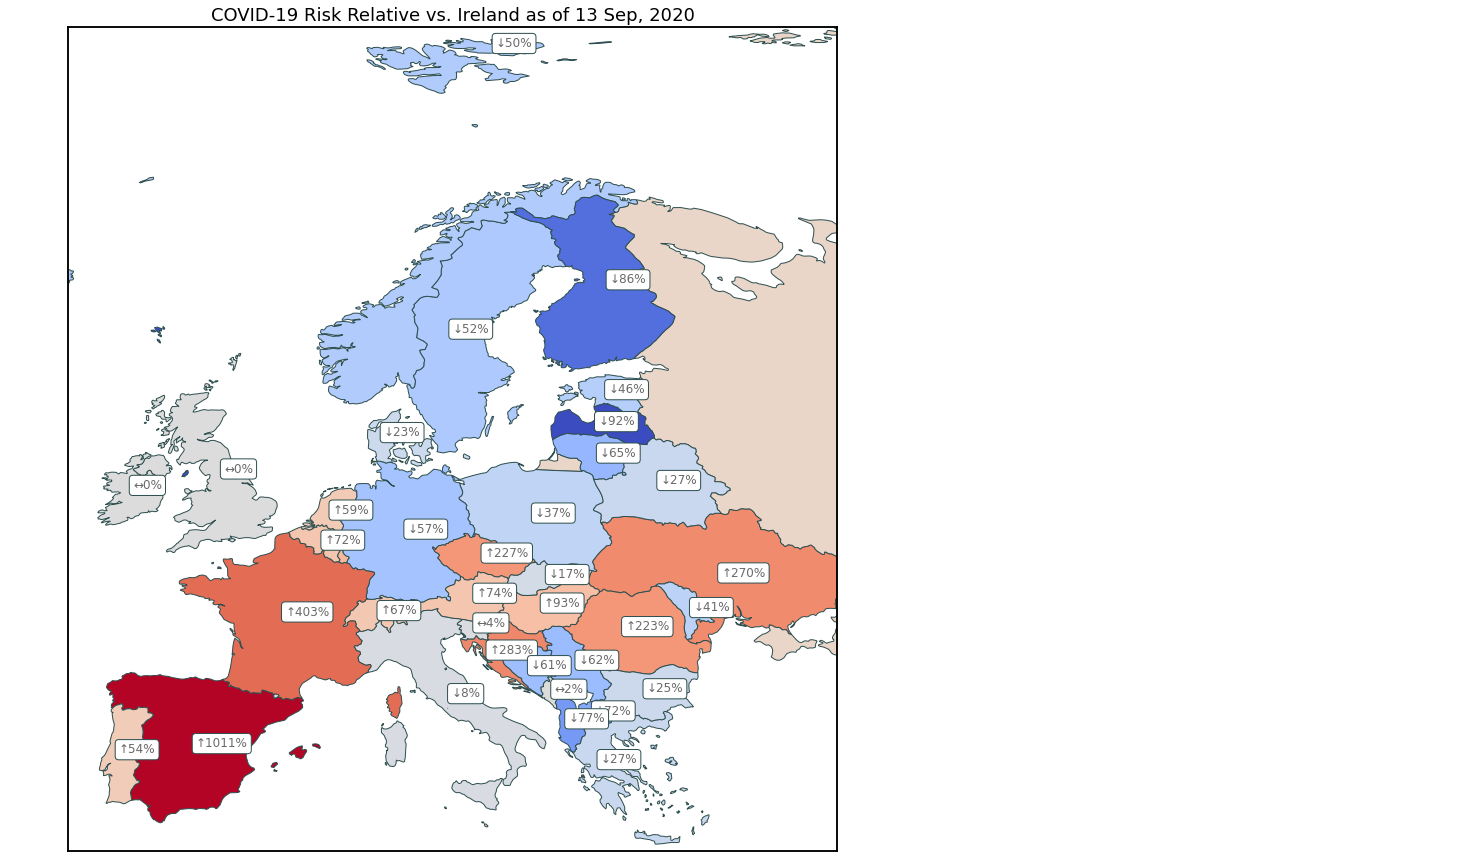

In [75]:
fig, ax = plt.subplots(figsize=(25, 25))

use_palette = 'coolwarm'
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cmap = matplotlib.cm.get_cmap(use_palette)


europe_map = map_with_data[map_with_data['continent']=='Europe']

europe_map.plot(column='rel_risk', cmap=use_palette, norm=norm, ax=ax, lw=1, edgecolor='darkslategrey')

min_area = 1e10

def label_rel_risk(rel_risk):
    adj_risk = -(100-int(100*(10**rel_risk)))
    if adj_risk<-5: return '↓{}%'.format(abs(adj_risk))
    elif adj_risk>5: return '↑{}%'.format(adj_risk)
    else: return '↔{}%'.format(abs(adj_risk))
    
europe_map[europe_map['rel_risk'].notnull()].apply(
    lambda row: ax.annotate(
        label_rel_risk(row['rel_risk']), xy=row['coords'], fontsize=12, color='dimgrey',
        bbox=dict(facecolor='w', edgecolor='darkslategrey', boxstyle='round,pad=.3', lw=1),
    ) if row['geometry'].area>min_area else None, axis=1
)
    
    
ax.set_xlim(-.1e7,0.32e7)
ax.set_ylim(3.7e6, 8.2e6)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

# cax = fig.add_axes([.48, .27, 0.025, .45])
# cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='vertical')
# cb.set_label('Relative Risk')


fig.tight_layout()

ax.set_title('COVID-19 Risk Relative vs. Ireland as of {}'.format(df['date'].max().strftime('%d %b, %Y')))


fig.savefig('../graphs/rel_risk_europe_map.png', dpi=300, format='png', bbox_inches='tight')

In [76]:
len(europe_map[(europe_map['rel_risk']<0) & (europe_map['region']=='eu')])/len(europe_map[(europe_map['region']=='eu')])

0.5

In [77]:
len(europe_map[europe_map['rel_risk']<0])/len(europe_map)

0.625

### The World

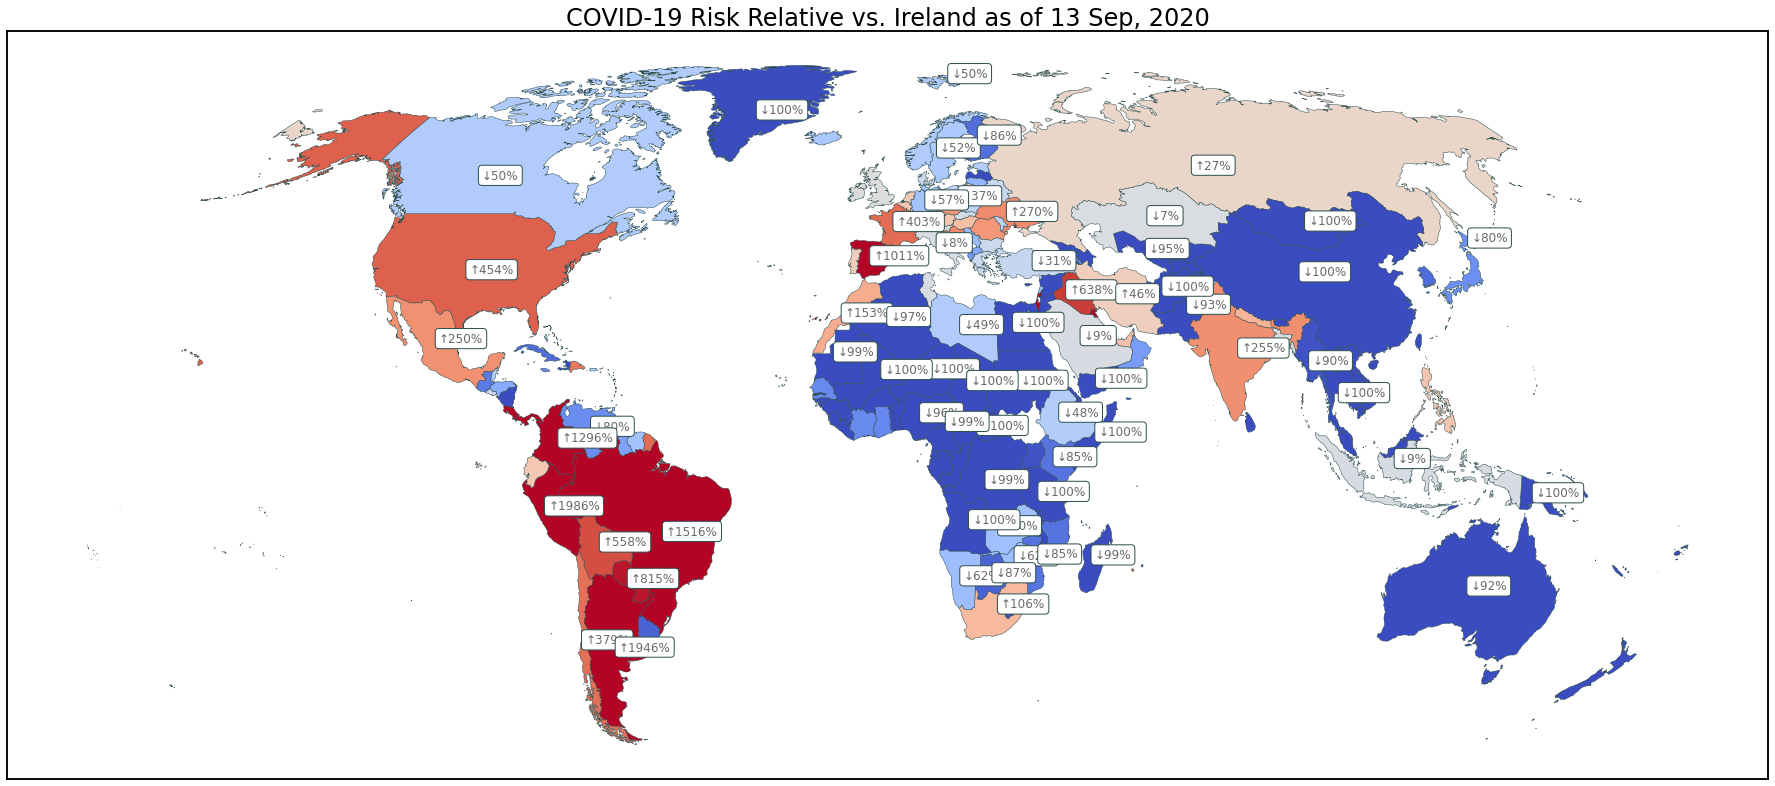

In [78]:
fig, ax = plt.subplots(figsize=(25, 25))

map_with_data.plot(column='rel_risk', cmap=use_palette, norm=norm, ax=ax, lw=.5, edgecolor='darkslategrey')
min_area = 3e11

map_with_data[map_with_data['rel_risk'].notnull()].apply(
    lambda row: ax.annotate(
        label_rel_risk(row['rel_risk']), xy=row['coords'], fontsize=12, color='dimgrey',
        bbox=dict(facecolor='w', edgecolor='darkslategrey', boxstyle='round,pad=.3', lw=1),
    ) if row['geometry'].area>min_area else None, axis=1
)


ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

fig.tight_layout()

ax.set_title('COVID-19 Risk Relative vs. Ireland as of {}'.format(df['date'].max().strftime('%d %b, %Y')), fontsize=24)

fig.savefig('../graphs/rel_risk_world_map.png', dpi=300, format='png', bbox_inches='tight')

In [79]:
len(map_with_data[map_with_data['rel_risk']<0])/len(map_with_data)

0.6473029045643154

In [81]:
map_with_data[map_with_data['rel_risk'].notnull()][['confirmed_cases_prevalence', 'baseline_prob_of_infection_per_week']].corr().values[0][1]**2

0.08377411951150325

## 1w Probabilities of Infection

### Europe

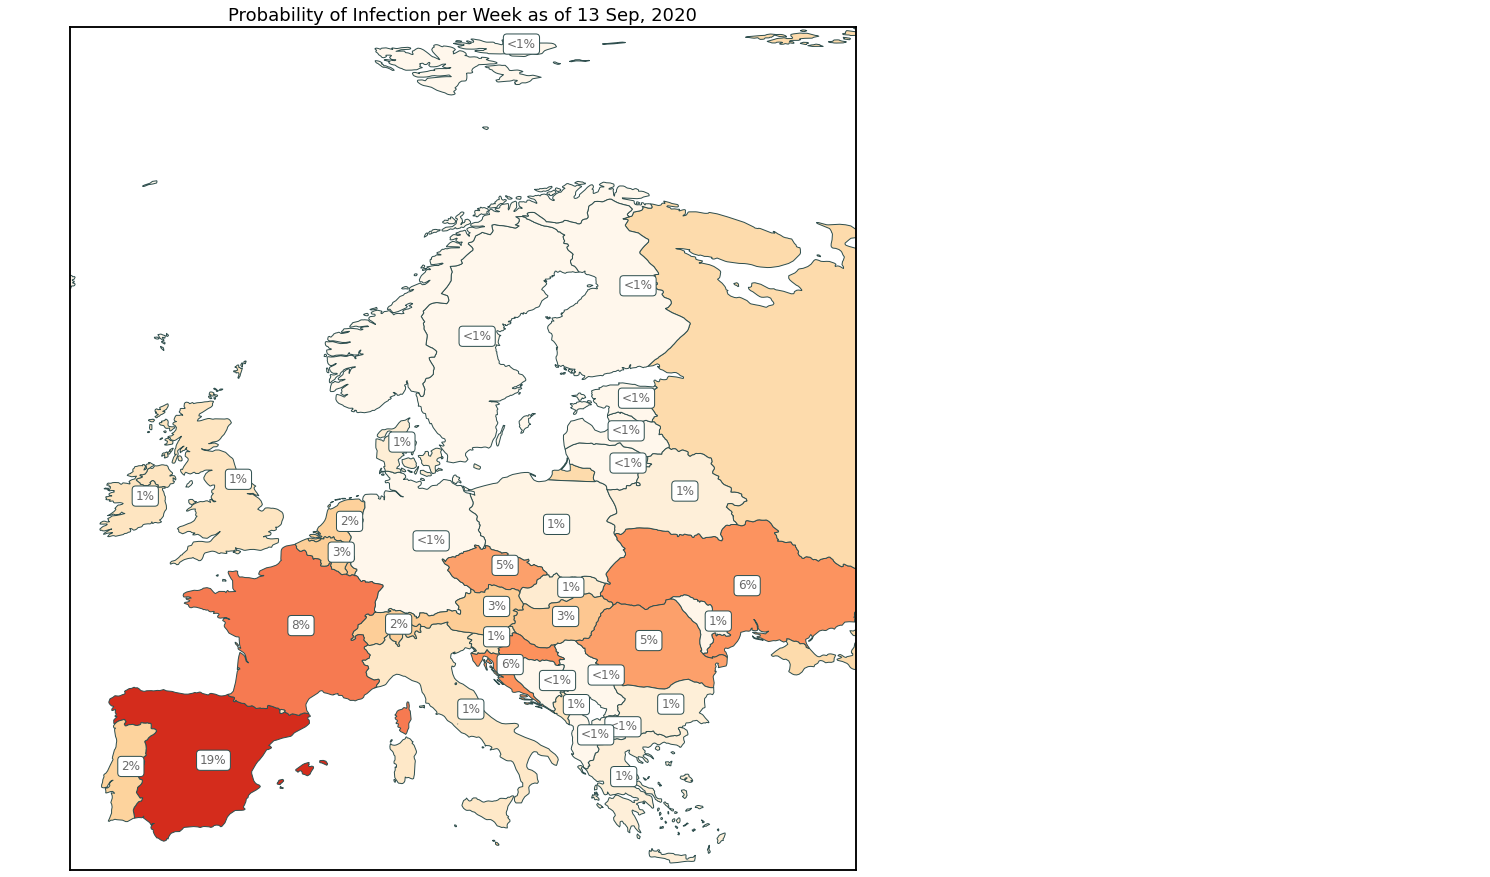

In [94]:
fig, ax = plt.subplots(figsize=(25, 25))

use_palette = 'OrRd'
norm = matplotlib.colors.Normalize(vmin=0, vmax=np.log10(50))
cmap = matplotlib.cm.get_cmap(use_palette)


europe_map = map_with_data[map_with_data['continent']=='Europe'].copy()

europe_map.plot(column='log_prob', cmap=use_palette, norm=norm, ax=ax, lw=1, edgecolor='darkslategrey')

min_area = 1e10

def label_baseline_prob_of_infection_per_week(prob):
    pct_prob = int(100*prob)
    
    pct_prob = '<1' if pct_prob==0 else pct_prob
    
    return '{}%'.format(pct_prob)
    
europe_map[europe_map['baseline_prob_of_infection_per_week'].notnull()].apply(
    lambda row: ax.annotate(
        label_baseline_prob_of_infection_per_week(row['baseline_prob_of_infection_per_week']), xy=row['coords'], fontsize=12, color='dimgrey',
        bbox=dict(facecolor='w', edgecolor='darkslategrey', boxstyle='round,pad=.3', lw=1),
    ) if row['geometry'].area>min_area else None, axis=1
)
    
    
ax.set_xlim(-.1e7,0.32e7)
ax.set_ylim(3.7e6, 8.2e6)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

# cax = fig.add_axes([.48, .27, 0.025, .45])
# cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='vertical')
# cb.set_label('Relative Risk')


fig.tight_layout()

ax.set_title('Probability of Infection per Week as of {}'.format(df['date'].max().strftime('%d %b, %Y')))


fig.savefig('../graphs/prob_infection_europe_map.png', dpi=300, format='png', bbox_inches='tight')

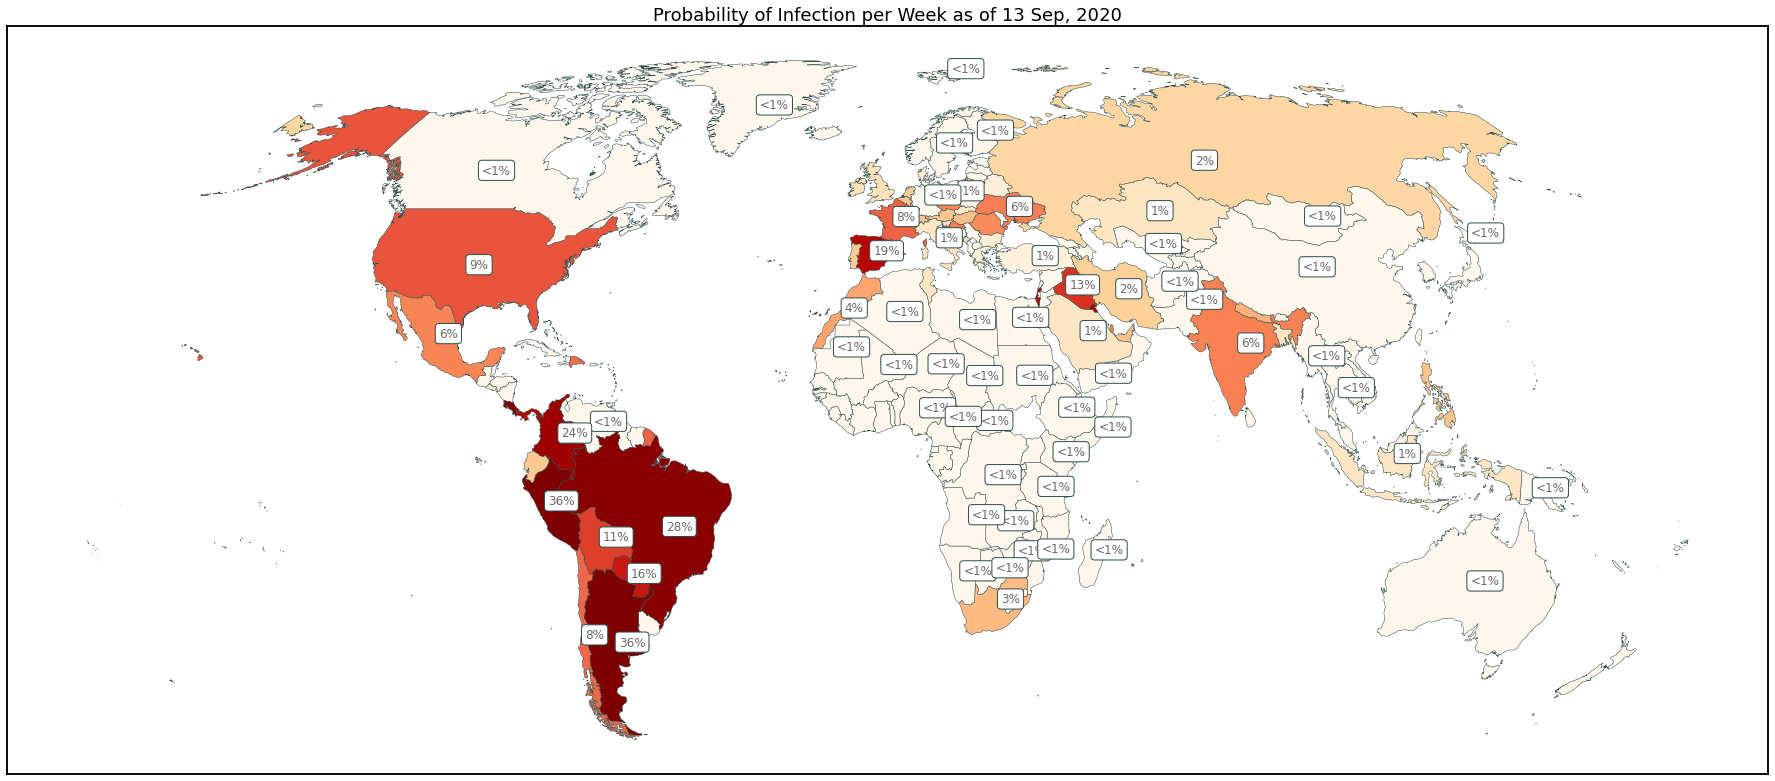

In [113]:
fig, ax = plt.subplots(figsize=(25, 25))

map_with_data.plot(column='log_prob', cmap=use_palette, norm=norm, ax=ax, lw=.5, edgecolor='darkslategrey')
min_area = 3e11

map_with_data[map_with_data['baseline_prob_of_infection_per_week'].notnull()].apply(
    lambda row: ax.annotate(
        label_baseline_prob_of_infection_per_week(row['baseline_prob_of_infection_per_week']), xy=row['coords'], fontsize=12, color='dimgrey',
        bbox=dict(facecolor='w', edgecolor='darkslategrey', boxstyle='round,pad=.3', lw=1),
    ) if row['geometry'].area>min_area else None, axis=1
)


ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

fig.tight_layout()

ax.set_title('Probability of Infection per Week as of {}'.format(df['date'].max().strftime('%d %b, %Y')))


fig.savefig('../graphs/prob_infection_world_map.png', dpi=300, format='png', bbox_inches='tight')

# COVID Protection Factor (CPF)

In [24]:
cc_reduction = .66
hh_reduction = 0.77
sd_reduction = ((.128-.026)/.128)
mw_reduction = .79

risk_reductions = [
    ('cc', cc_reduction), ('hh', hh_reduction), ('sd', sd_reduction), ('mw', mw_reduction)
]

all_combinations = list(
    itertools.chain.from_iterable(
        [list(itertools.combinations(risk_reductions, r+1)) 
         for r in range(len(risk_reductions))
        ]
    )
)

def calculate_1w_prob(data, combos, period=7):
    
    probs = []
    
    # The baseline probability; no mitigations
    baseline = prob_of_infection(
        p=data['prob_close_contact_transmission'], 
        cc=close_contacts_per_day, 
        days=period
    ).iloc[-1]
    
    for combo in combos:
        for effectiveness in np.arange(.5, 1.01, .05):
            combo_dict = {mitigation: reduction for (mitigation, reduction) in combo}

            cc_reduction = combo_dict['cc']*effectiveness if 'cc' in combo_dict else 0
            hh_reduction = combo_dict['hh']*effectiveness if 'hh' in combo_dict else 0
            sd_reduction = combo_dict['sd']*effectiveness if 'sd' in combo_dict else 0
            mw_reduction = combo_dict['mw']*effectiveness if 'mw' in combo_dict else 0
            
            cc = 'cc' in combo_dict
            hh = 'hh' in combo_dict
            sd = 'sd' in combo_dict
            mw = 'mw' in combo_dict
            
            prob_cc_transmission = data['prob_close_contact_transmission']

            prob = prob_of_infection(
                p=data['prob_close_contact_transmission']*(1-hh_reduction)*(1-sd_reduction)*(1-mw_reduction), 
                cc=close_contacts_per_day*(1-cc_reduction), 
                days=period
            ).iloc[-1]

            probs.append((int(effectiveness*100), np.log10(baseline/prob), (cc, hh, sd, mw)))
            
    return pd.DataFrame(probs, columns=['e', 'p', 'r'])

probs = calculate_1w_prob(data, all_combinations)

probs_matrix = probs.pivot(index='e', columns='r').sort_index(ascending=False)


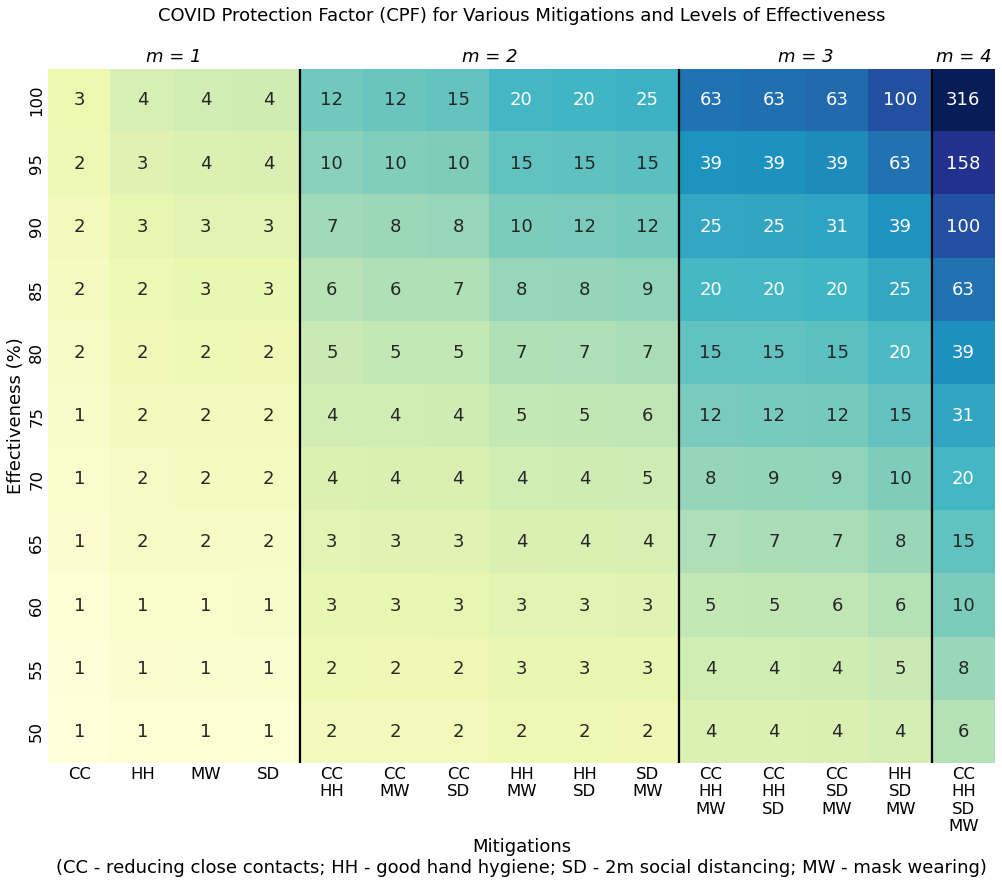

In [40]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(
    # Sort by column means
    probs_matrix.T.assign(m=probs_matrix.T.mean(axis=1)).sort_values('m').drop('m', axis=1).T, 
    ax=ax, annot=True, cmap='YlGnBu', square=True, cbar=False
)

ax.tick_params(axis='both', which='both', length=0)

ax.set_ylabel('Effectiveness (%)')
ax.set_yticklabels(
    [label.get_text() for label in ax.get_yticklabels()], va='center'
)

ax.set_xlabel('Mitigations\n(CC - reducing close contacts; HH - good hand hygiene; SD - 2m social distancing; MW - mask wearing)')
ax.set_xticklabels([
    'CC', 'HH', 'MW', 'SD', 
    'CC\nHH', 'CC\nMW', 'CC\nSD', 'HH\nMW', 'HH\nSD', 'SD\nMW',
    'CC\nHH\nMW', 'CC\nHH\nSD', 'CC\nSD\nMW', 'HH\nSD\nMW',
    'CC\nHH\nSD\nMW'
], rotation=0, ha='center')

# A hack to label the cells with the values converted back from logs.
[text.set_text(int(round(10**float(text.get_text()), 1))) for text in ax.texts]

ax.axvline(4, c='k')
ax.axvline(10, c='k')
ax.axvline(14, c='k')
ax.text(2, ax.get_ylim()[1]-.1, 'm = 1', ha='center', style='oblique', rotation=0)
ax.text(7, ax.get_ylim()[1]-.1, 'm = 2', ha='center', style='oblique', rotation=0)
ax.text(12, ax.get_ylim()[1]-.1, 'm = 3', ha='center', style='oblique', rotation=0)
ax.text(14.5, ax.get_ylim()[1]-.1, 'm = 4', ha='center', style='oblique', rotation=0)

ax.set_title('COVID Protection Factor (CPF) for Various Mitigations and Levels of Effectiveness\n\n')

fig.tight_layout()

fig.savefig('../graphs/cpf_for_ireland.png', format='png', dpi=200, bbox_inches='tight')